## Download the dataset from the kaggle

In [1]:
# Import Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify your custom path
custom_path = r"D:\code files\Data Science\Projects\Personalized Healthcare Cost Prediction\data"
os.makedirs(custom_path, exist_ok=True)

# Download dataset
api.dataset_download_files(
    'mirichoi0218/insurance', 
    path=custom_path, 
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance


## Import necessary libraries

In [2]:
# For Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Model Preprocessing & Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# For Model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

In [3]:
df = pd.read_csv('../data/insurance.csv')
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [6]:
df.describe(include='all').T

count unique        top  freq          mean           std  \
age       1338.0    NaN        NaN   NaN     39.207025      14.04996   
sex         1338      2       male   676           NaN           NaN   
bmi       1338.0    NaN        NaN   NaN     30.663397      6.098187   
children  1338.0    NaN        NaN   NaN      1.094918      1.205493   
smoker      1338      2         no  1064           NaN           NaN   
region      1338      4  southeast   364           NaN           NaN   
charges   1338.0    NaN        NaN   NaN  13270.422265  12110.011237   

                min         25%       50%           75%          max  
age            18.0        27.0      39.0          51.0         64.0  
sex             NaN         NaN       NaN           NaN          NaN  
bmi           15.96    26.29625      30.4      34.69375        53.13  
children        0.0         0.0       1.0           2.0          5.0  
smoker          NaN         NaN       NaN           NaN          NaN  
region          NaN         NaN       NaN           NaN          NaN  
charges   1121.8739  4740.28715  9382.033  16639.912515  63770.42801

In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**Observation:**
- No missing values found.

In [8]:
df.duplicated().mean()

0.0007473841554559044

In [9]:
df[df.duplicated(keep=False)]

age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631

**There is only 2 duplicated rows I drop one of them**

In [10]:
df = df.drop_duplicates()
df.duplicated().mean()

0.0

# Univariate Analysis

In [11]:
categorical_features = ['sex','children','smoker','region']

**Let's look into categorical features unique values and it's count**

In [12]:
def display_value_counts(df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10)) # Create a 2x2 grid for subplots
    axes = axes.flatten()  # Flatten to easily iterate over

    for i, col in enumerate(categorical_features):
        ax = axes[i]
        sns.countplot(x=df[col], ax=ax,hue=df[col], palette='pastel')
        
        # Add labels to bars
        for bar in ax.containers:
            ax.bar_label(bar)

    # Remove any unused subplots if there are fewer than 4 features
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

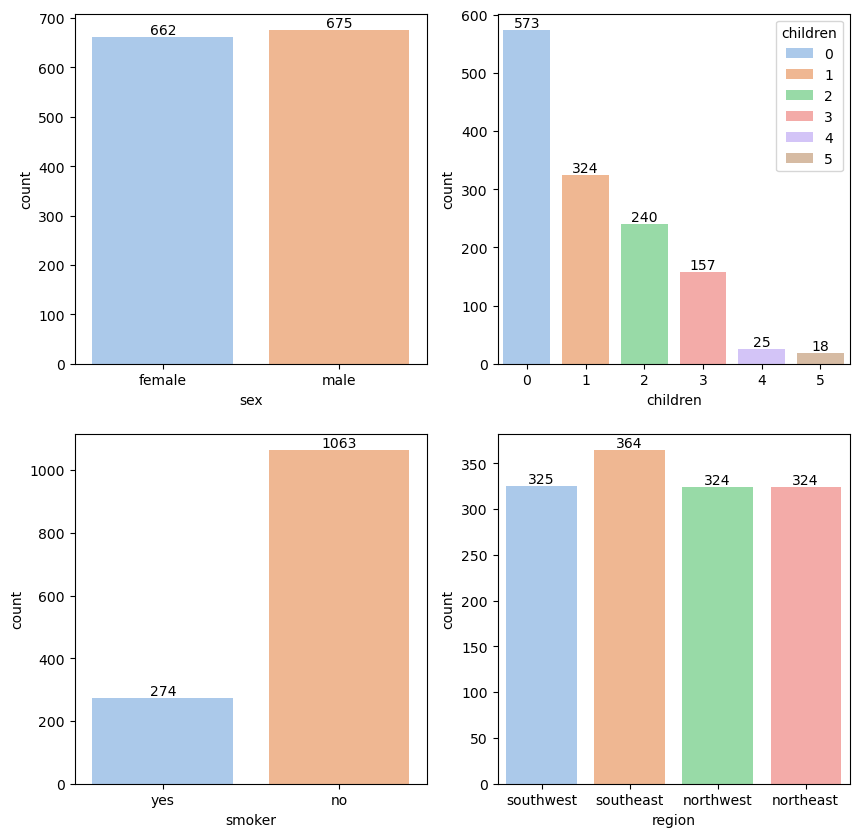

In [13]:
display_value_counts(df)

**Observation:**
- sex and region features are well balanced so there is no problem here.
- children and smoker features very imbalanced if these features have high significance with the charges(target feature) this might downgrade the Linear, Lasso & Ridge regressions performance.

## Observing the distributions of numerical features age,bmi,charges

Text(0.5, 0.98, 'Distribution of numerical features')

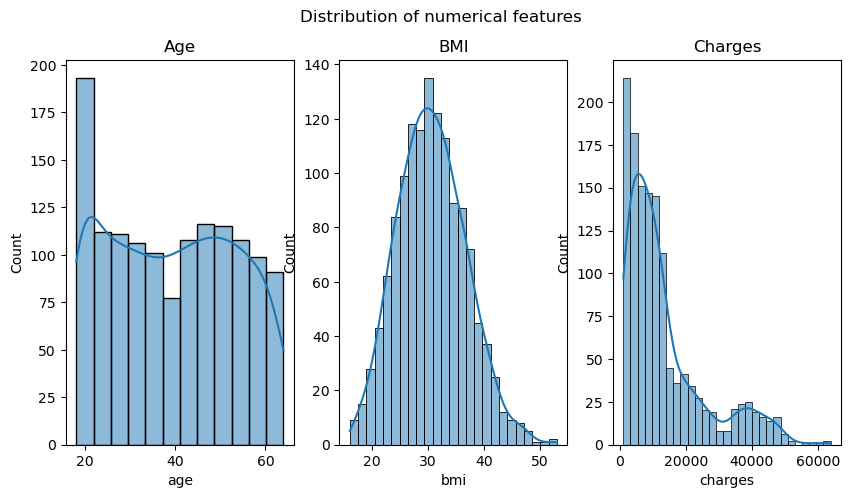

In [14]:
fig, axes = plt.subplots(1,3,figsize=(10,5))# creates Figure for Visualizing the data and add a grid of Axes(1 row ; 3 Columns)

sns.histplot(ax=axes[0],data=df,x="age",kde=True)# Plot a histogram of the "age" column with a kernel density estimate (KDE) on the first subplot.
axes[0].title.set_text("Age")# Set the title of the first subplot to "age".

sns.histplot(ax=axes[1],data=df,x="bmi",kde=True)# Plot a histogram of the "bmi" column with a kernel density estimate (KDE) on the second subplot.
axes[1].title.set_text("BMI")# Set the title of the second subplot to "BMI".

sns.histplot(ax=axes[2],data=df,x="charges",kde=True)# Plot a histogram of the "bmi" column with a kernel density estimate (KDE) on the third subplot.
axes[2].title.set_text("Charges")# Set the title of the third subplot to "Charges".

plt.suptitle("Distribution of numerical features")#set title of the figure

**Observation:**
- bmi feature is normally distributed if this feature is significance with predicting charges then Linear, Ridge & Lasso regressions performance would be good.
- The charges (target) feature is rightly skewed so we can expect outliers.

## Detecting Outliers

Text(0.5, 0.98, 'Detection of outliers in the numerical features')

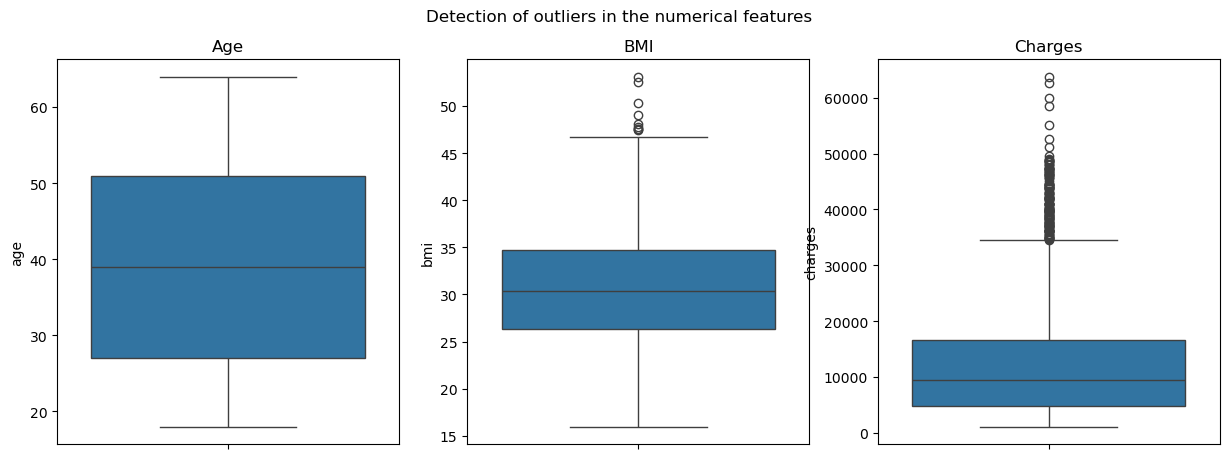

In [15]:
fig, axes = plt.subplots(1,3,figsize=(15,5)) # creates Figure for Visualizing the data and add a grid of Axes(1 row ; 3 Columns)

sns.boxplot(ax=axes[0], data=df['age']) # Boxplot for the age feature to detect the outliers
axes[0].title.set_text("Age")# Set the title of the first subplot to "age".

sns.boxplot(ax=axes[1], data=df['bmi']) # Boxplot for the bmi feature to detect the outliers
axes[1].title.set_text("BMI")# Set the title of the first subplot to "bmi".

sns.boxplot(ax=axes[2], data=df['charges']) # Boxplot for the charges feature to detect the outliers
axes[2].title.set_text("Charges")# Set the title of the first subplot to "charges".


plt.suptitle('Detection of outliers in the numerical features')

In [16]:
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bmi_outliers = df[(df['bmi'] < lower_bound) | (df['bmi'] > upper_bound)]
print(bmi_outliers)

      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270


**In healthcare, extreme BMIs might genuinely represent certain individuals' conditions. Removing them could lead to loss of important information.**

In [17]:
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

charges_outliers = df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)]

# Calculate the percentage of outliers
percentage_outliers = (len(charges_outliers) / len(df)) * 100

# Display the results
print(f"Number of outliers: {len(charges_outliers)}")
print(f"Percentage of outliers in charges feature: {percentage_outliers:.2f}%")

Number of outliers: 139
Percentage of outliers in charges feature: 10.40%


In [18]:
df['charges'].skew()

1.5153909108403483

**Observation:**
- The distribution is right skewed and has 10.4% of outliers removing or handling may cause loss of information.
- Linear,Reidge & Lasso Regression models performance may get effected by this distribution and outliers.

# Bivariate Analysis

### Scatter plot of Age vs BMI to observe patterns

<Axes: xlabel='age', ylabel='bmi'>

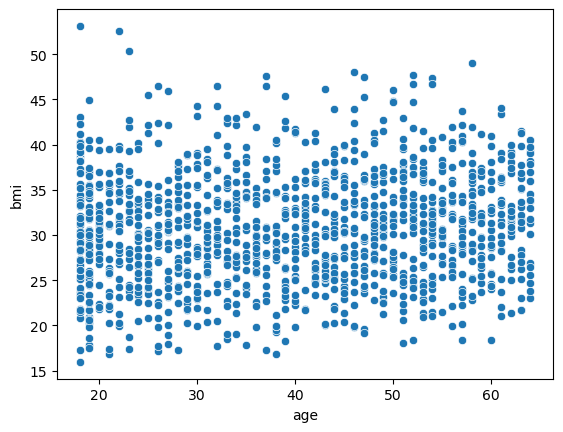

In [19]:
sns.scatterplot(data=df, x='age', y='bmi')

In [20]:
df['age'].corr(df['bmi'])

0.10934361041896885

**Observation:**
- There is no pattern here that means age doesn't effect BMI

### Scatter plot of Age vs Charges

<Axes: xlabel='age', ylabel='charges'>

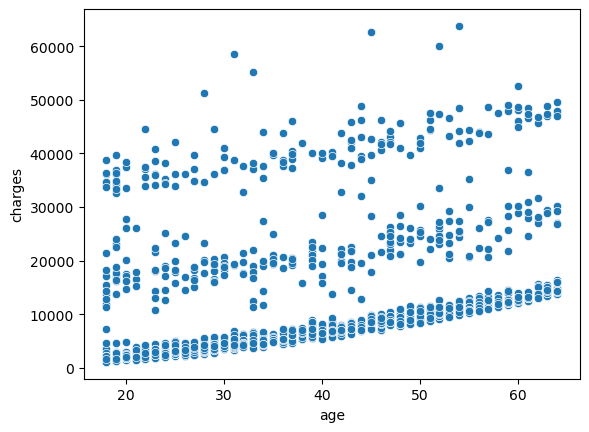

In [21]:
sns.scatterplot(data=df, x='age', y='charges')

In [22]:
df['age'].corr(df['charges'])

0.2983082125097863

**Observation:**
- I can see slight upward linear relationship but divided into 3 clusters may be any of a feature grouping them that most probably smoker or children feature.
- Let's apply hue for smoker, sex, children and region to identify what feature makeing clusters here.

<Axes: xlabel='age', ylabel='charges'>

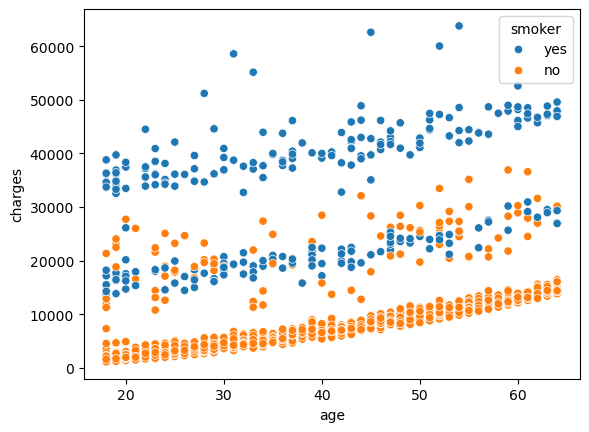

In [23]:
sns.scatterplot(data=df, x='age', y='charges',hue='smoker')

**Observation**:
- Here I can clearly see that those who don't do smoking they got less charges compared to others. The smoker feature seriously correalated to charges feature and smoker feature making the clusters.
- That means smoker and charges features are highly correlated.

<Axes: xlabel='age', ylabel='charges'>

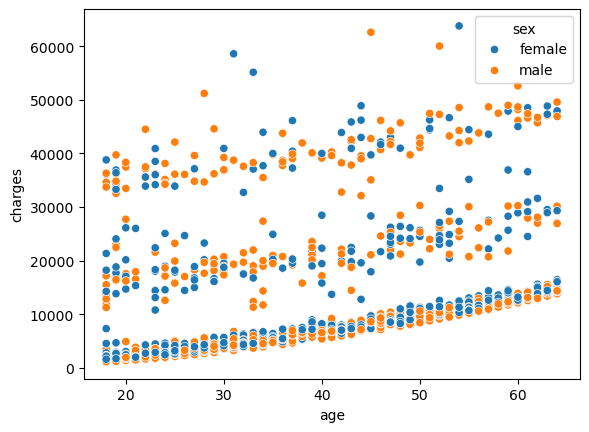

In [24]:
sns.scatterplot(data=df, x='age', y='charges', hue='sex')

**Observation:**
- Look's like there is no significance of sex that effect charges.

<Axes: xlabel='age', ylabel='charges'>

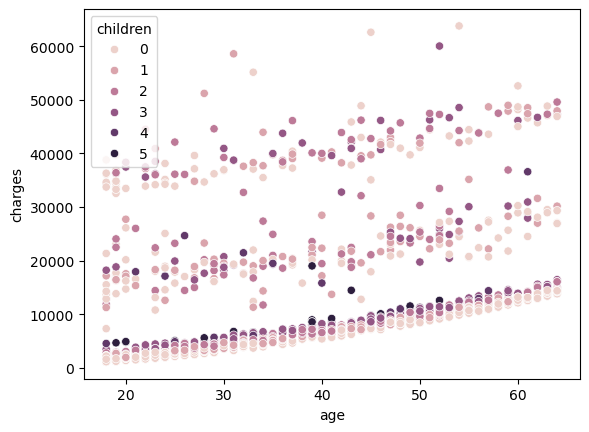

In [25]:
sns.scatterplot(data=df, x='age', y='charges',hue='children')

In [26]:
df['charges'].corr(df['children'])

0.06738935083963245

**Observation:**
- There very less significance of children with charges it's because children feature is very imbalanced.

<Axes: xlabel='age', ylabel='charges'>

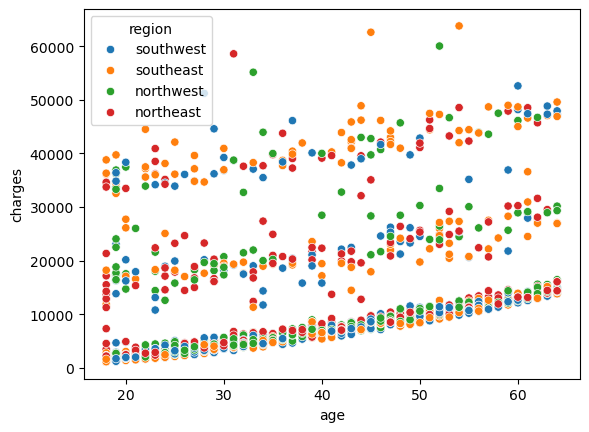

In [27]:
sns.scatterplot(data=df, x='age', y='charges', hue='region')

### BMI vs Charges Scatter plot

<Axes: xlabel='bmi', ylabel='charges'>

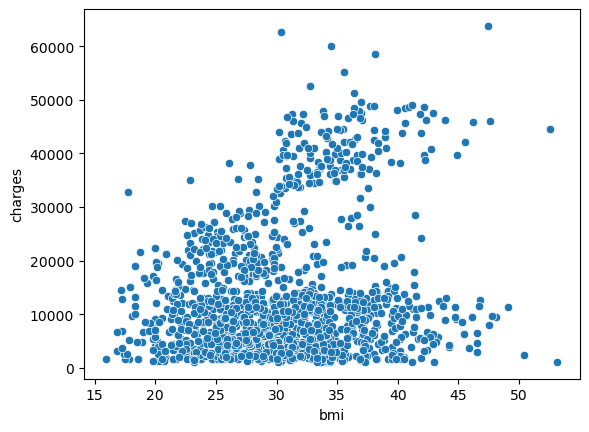

In [28]:
sns.scatterplot(data=df, x='bmi', y='charges')

In [29]:
df['bmi'].corr(df['charges'])

0.19840083122624935

Let's check hue = 'smoker' to get better understanding**

<Axes: xlabel='bmi', ylabel='charges'>

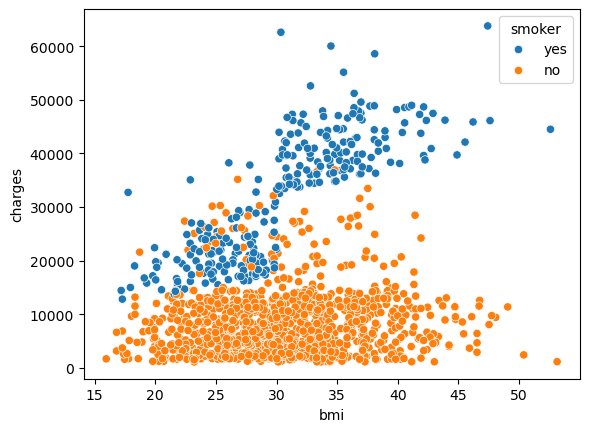

In [30]:
sns.scatterplot(data=df, x='bmi', y='charges',hue='smoker')

**Observation:**
- Most of the individuals got less charges when there BMI < 30 that means they considered healthy because they are not obese.
- But some individuals also got less charges even there BMI >30 that means BMI  alone is not effecting charges.
- Most  probably it's because the individuals who are obese or BMI > 30 but they don't smoke and younger or middle aged thus they got less charges
- The individuals who are obese, does smoking and  middle aged or older got high charges.
- May be region,sex,children also effect bmi vs charges let's observe those.

<Axes: xlabel='bmi', ylabel='charges'>

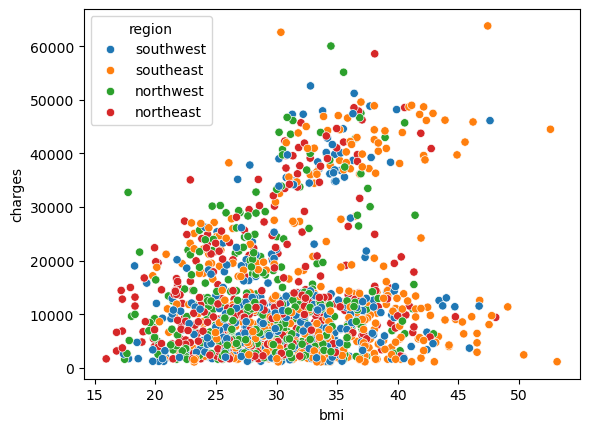

In [31]:
sns.scatterplot(data=df, x='bmi', y='charges',hue='region')

<Axes: xlabel='bmi', ylabel='charges'>

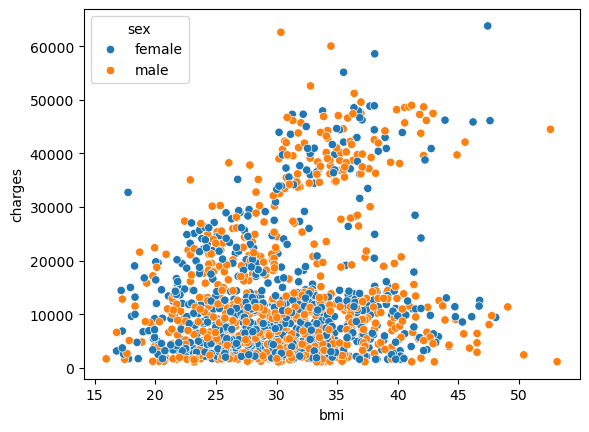

In [32]:
sns.scatterplot(data=df, x='bmi', y='charges',hue='sex')

<Axes: xlabel='bmi', ylabel='charges'>

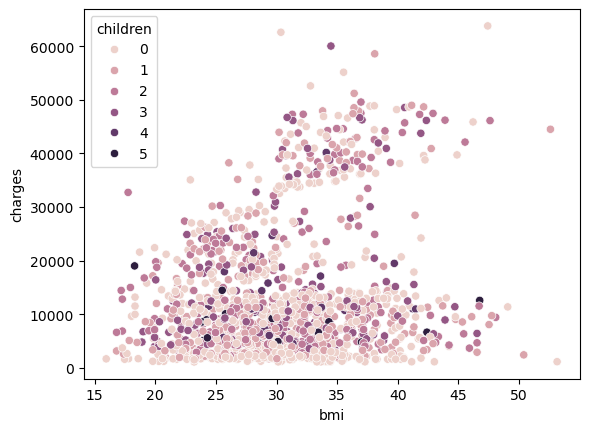

In [33]:
sns.scatterplot(data=df, x='bmi', y='charges',hue='children')

**Observation: No these features are not much significance for bmi vs charges may be individually these features may effect charges let's check it**

<Axes: xlabel='children', ylabel='charges'>

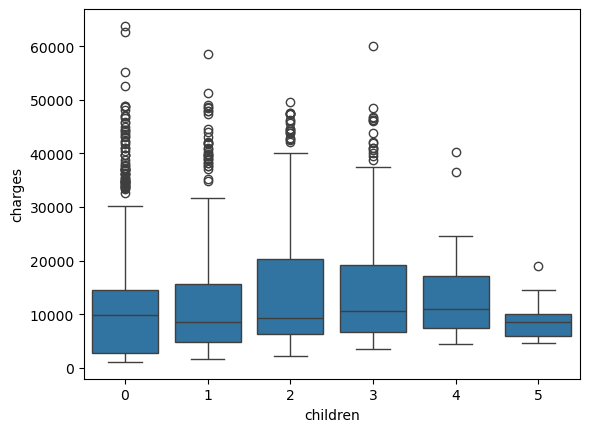

In [34]:
sns.boxplot(data=df, x='children', y='charges')

**Observation:**
- It look's like the individuals who has no or less no.of childrens tend to have high charges but I don't think it's the case.
- It is because the children categorical feature is imbalanced just look at it's value counts children=0 are 573 and children=5 are just 18 counts thus we can see this pattern.

<Axes: xlabel='region', ylabel='charges'>

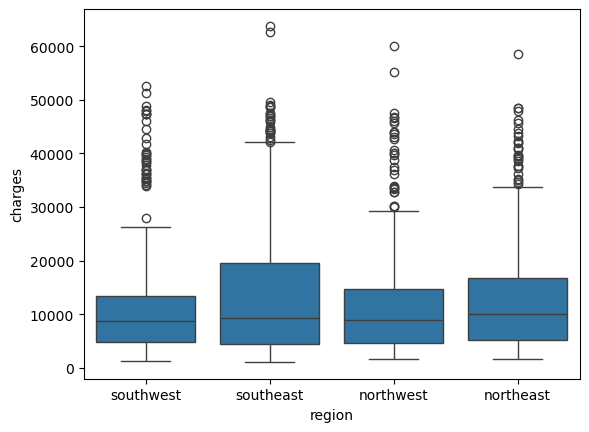

In [35]:
sns.boxplot(data=df, x='region', y='charges')

<Axes: xlabel='sex', ylabel='charges'>

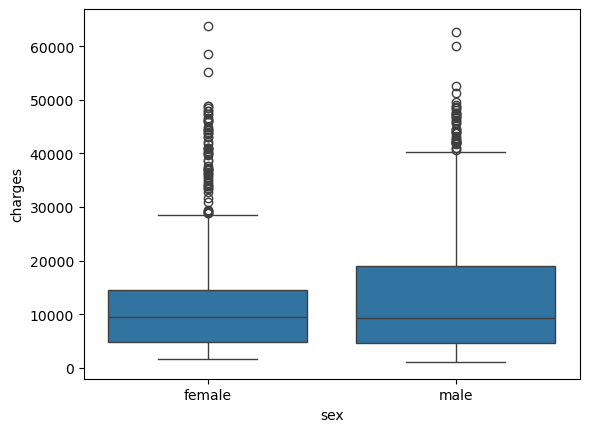

In [36]:
sns.boxplot(data=df, x='sex', y='charges')

**Observation: Thus these features doesn't effecting charges alone**

**Now, observe the correalated for each features before that I have to encode all the categorical features**

In [37]:
df1 = df.copy()
le = LabelEncoder()
df1.sex = le.fit_transform(df1.sex)
df1.smoker = le.fit_transform(df1.smoker)
df1.region = le.fit_transform(df1.region)

In [38]:
df1.head()

age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520

<Axes: >

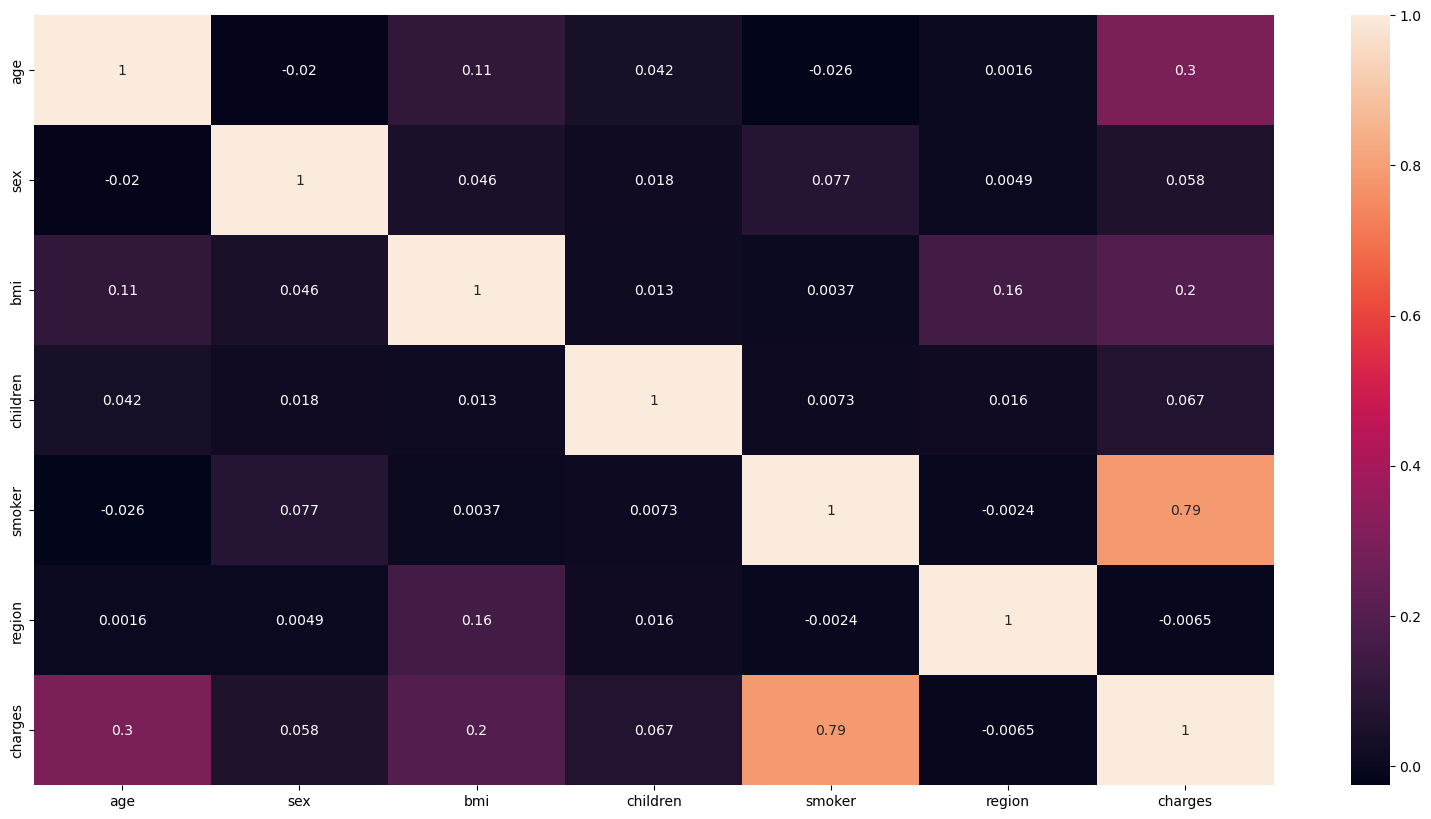

In [39]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=df1.corr(),annot=True)

**Observation:**
- age vs charges and bmi vs charges features are weak positively correlated
- smoker vs charges are strong postitively correlated

**So the models are dependent with smoker feature predicts higher charges values if smoker = 1**

In [40]:
X = df1.drop('charges',axis=1)
X.head()

age  sex     bmi  children  smoker  region
0   19    0  27.900         0       1       3
1   18    1  33.770         1       0       2
2   28    1  33.000         3       0       2
3   33    1  22.705         0       0       1
4   32    1  28.880         0       0       1

In [41]:
y = df1['charges']
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [42]:
# Divide into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [43]:
# Linear Regression

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

y_pred_lr = lr_model.predict(X_test)

In [44]:
def evaluate_model(y_test, y_pred):
    print(f'R²: {r2_score(y_test, y_pred)}')
    print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

evaluate_model(y_test, y_pred_lr)  # For Linear Regression

R²: 0.8068466322629111
RMSE: 5957.60879981646
MAE: 4182.353155288298


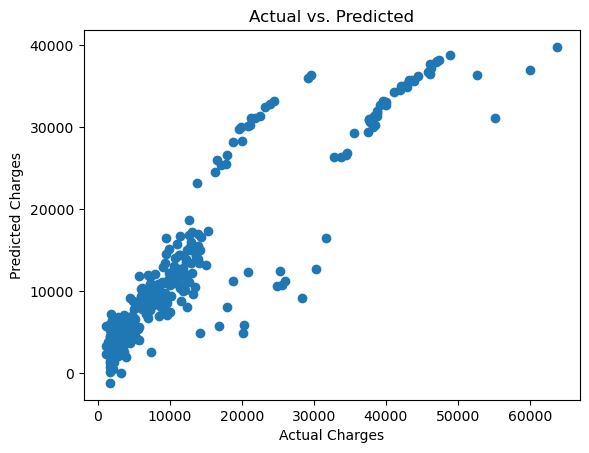

In [45]:
plt.scatter(y_test, y_pred_lr)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted')
plt.show()

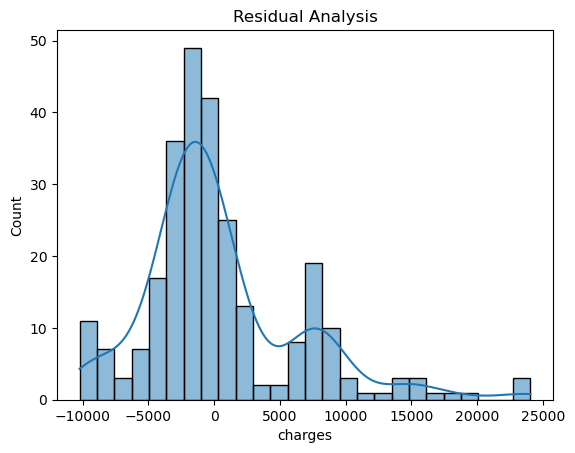

In [46]:
residuals = y_test - y_pred_lr
sns.histplot(residuals, kde=True)
plt.title('Residual Analysis')
plt.show()

**Observation:**
- I already expected that linear regression couldn't be good model for this dataset. Same goes to Lasso & Ridge as well.
- Thus, I have to relay on tree based regression models.

## Model Building and Model Evaluation to get best model

In [47]:
# Dictionary of models with their hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge": (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
    "Lasso": (Lasso(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
    "Random Forest": (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    "Gradient Boosting": (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1]}),
    "Decision Tree": (DecisionTreeRegressor(), {'max_depth': [3, 5, 10]}),
    "XGBoost": (XGBRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1]})
}

# Loop through models and apply GridSearchCV
best_models = {}
for name, (model, params) in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best Parameters for {name}: {grid.best_params_}")
    print(f"Best Score for {name}: {-grid.best_score_:.4f}")
    print('\n------------------------------------------')

# Evaluate the best model
best_model_name = max(best_models, key=lambda name: r2_score(y_test, best_models[name].predict(X_test)))
best_model = best_models[best_model_name]

y_pred = best_model.predict(X_test)
print("\nBest Model:", best_model_name)
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

Training Linear Regression...
Best Parameters for Linear Regression: {}
Best Score for Linear Regression: 37523328.9670

------------------------------------------
Training Ridge...
Best Parameters for Ridge: {'alpha': 1}
Best Score for Ridge: 37516972.6477

------------------------------------------
Training Lasso...
Best Parameters for Lasso: {'alpha': 10}
Best Score for Lasso: 37511714.3080

------------------------------------------
Training Random Forest...
Best Parameters for Random Forest: {'max_depth': 5, 'n_estimators': 100}
Best Score for Random Forest: 21636552.7862

------------------------------------------
Training Gradient Boosting...
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 50}
Best Score for Gradient Boosting: 21665470.8924

------------------------------------------
Training Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 5}
Best Score for Decision Tree: 23653851.4156

------------------------------------------
Tr

**Observation:**
- Among all the models Random forest regressor performce is best.

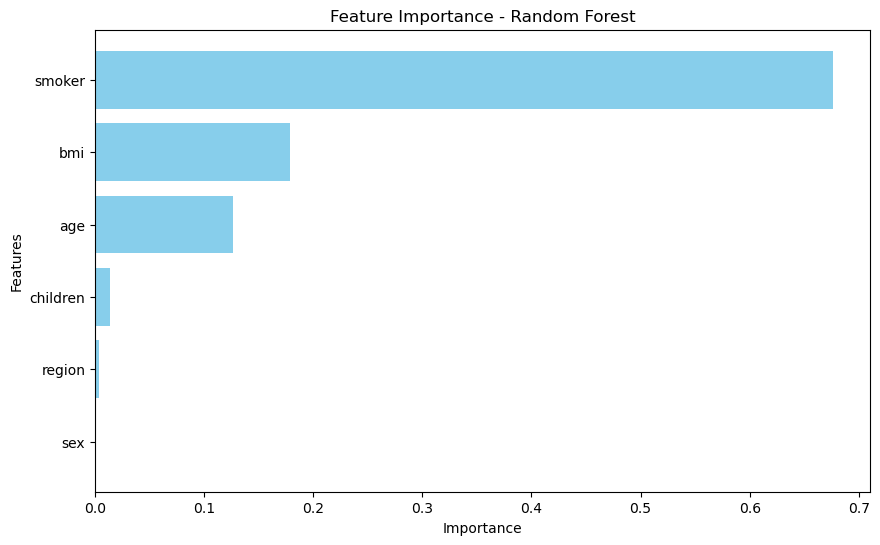

In [48]:
# features are in `X_train`
feature_importance = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()  # Reverse the order to show the highest importance at the top
plt.show()

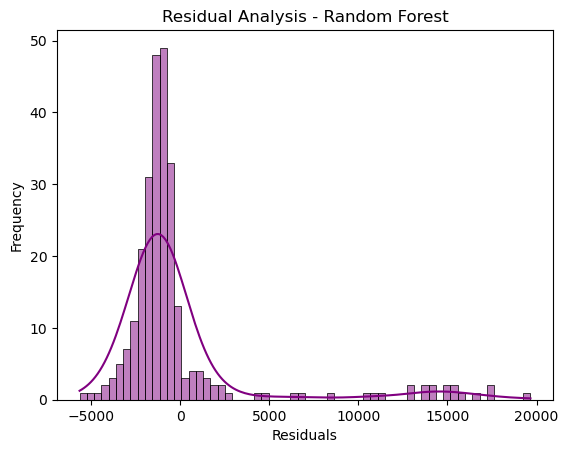

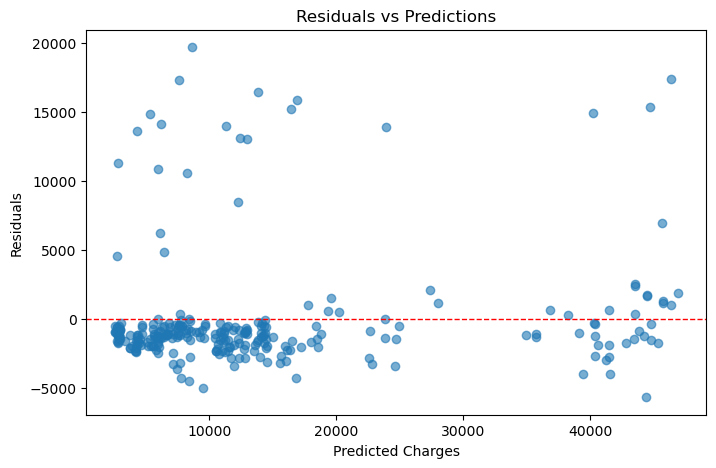

In [49]:
# Calculate residuals
residuals = y_test - y_pred  # Replace y_pred_rf with your Random Forest predictions

# Plot residual histogram
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residual Analysis - Random Forest')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs. predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.show()

In [50]:
df1.head()

age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520

In [51]:
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [52]:
region_category={'southwest':3,'southeast':2,'northwest':1,'northeast':0}
smoker_category={'yes':1,'no':0}
sex_category={'female':0,'male':1}

In [53]:
X

age  sex     bmi  children  smoker  region
0      19    0  27.900         0       1       3
1      18    1  33.770         1       0       2
2      28    1  33.000         3       0       2
3      33    1  22.705         0       0       1
4      32    1  28.880         0       0       1
...   ...  ...     ...       ...     ...     ...
1333   50    1  30.970         3       0       1
1334   18    0  31.920         0       0       0
1335   18    0  36.850         0       0       2
1336   21    0  25.800         0       0       3
1337   61    0  29.070         0       1       1

[1337 rows x 6 columns]

In [54]:
best_model.predict([[19,0,30.0,0,1,3]])

D:\Dichu\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([22705.00200836])

In [55]:
X_test

age  sex     bmi  children  smoker  region
900    49    1  22.515         0       0       0
1064   29    0  25.600         4       0       3
1256   51    0  36.385         3       0       1
298    31    1  34.390         3       1       1
237    31    1  38.390         2       0       2
...   ...  ...     ...       ...     ...     ...
534    64    1  40.480         0       0       2
542    63    0  36.300         0       0       2
760    22    0  34.580         2       0       0
1284   61    1  36.300         1       1       3
1285   47    0  24.320         0       0       0

[268 rows x 6 columns]

In [56]:
# Define the predict_charges function
def predict_charges(age, sex, bmi, children, smoker, region):
    import pandas as pd
    
    # Category mappings
    region_category = {'southwest': 3, 'southeast': 2, 'northwest': 1, 'northeast': 0}
    smoker_category = {'yes': 1, 'no': 0}
    sex_category = {'female': 0, 'male': 1}
    
    # Convert categorical inputs to numerical values
    sex_encoded = sex_category[sex.lower()]
    smoker_encoded = smoker_category[smoker.lower()]
    region_encoded = region_category[region.lower()]
    
    # Prepare input for prediction
    input_data = {'age':age,'sex':sex_encoded,'bmi':bmi,'children':children,'smoker':smoker_encoded,'region':region_encoded}
    input_data = pd.DataFrame([input_data])
    
    # Predict charges using the trained model
    predicted_charges = best_model.predict(input_data)
    
    # Return the prediction
    return predicted_charges[0]

In [57]:
# Call the function with sample inputs
predicted_charge = predict_charges(19, 'female', 30, 0, 'yes', 'southwest')
print(f"Predicted Healthcare cost: ${predicted_charge:.2f}")

Predicted Healthcare cost: $22705.00


In [58]:
import joblib
joblib.dump(best_model, 'healthcare_cost_model.pkl')

['healthcare_cost_model.pkl']